<a href="https://colab.research.google.com/github/Mgrinet/housing-price-analysis/blob/master/housing_market_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avaliação de Mercado Imobiliario com Data Science & Machine Learning


# Configuração

Primeiro, vamos garantir que este notebook funcione bem tanto no python 2 quanto no 3, importe alguns módulos comuns, garanta que o MatplotLib plote figuras em linha e prepare uma função para salvar os números:

In [0]:
# Para suportar o python 2 e o python 3
from __future__ import division, print_function, unicode_literals

# Importações comuns
import numpy as np
import os

# para tornar a saída deste portátil estável em todas as execuções
np.random.seed(42)

# Para traçar as figuras
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore avisos inúteis (ver SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Obtendo os dados

Em ambientes típicos, seus dados estariam disponíveis em um banco de dados relacional (ou algum outro armazenamento de dados comum) e espalhados por várias tabelas/documentos/arquivos. Para acessá-lo, você primeiro precisa obter suas credenciais e acessar as autorizações, e se familiarizar com o esquema de dados.

Neste projeto, no entanto, as coisas são muito mais simples: você faremos o download de um único arquivo compactado, housing.tgz, que contém um arquivo de valores separados por vírgula (CSV) chamado housing.csv com todos os dados.

Aqui está a função para buscar os dados

In [0]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Agora, quando você chama `fetch_housing_data()`, ele cria um diretório data / housing em seu espaço de trabalho, faz o download do arquivo housing.tgz e extrai o arquivo housing.csv deste diretório.

Agora vamos carregar os dados usando Pandas. Mais uma vez você deve escrever uma pequena função para carregar os dados:

In [0]:
fetch_housing_data()

In [0]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

Essa função retorna um objeto Pandas DataFrame contendo todos os dados.
Vamos dar uma olhada nas cinco primeiras linhas usando o método `head()` do `DataFrame()`

In [0]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Cada linha representa um distrito. Existem 10 atributos (nossos features): longitude, latitude, housing_median_age, total_rooms, total_bedroom, população, household, median_income, median_house_value e ocean_proximity.

O método `info()` é útil para obter uma descrição rápida dos dados, em particular o número total de linhas e o tipo e o número de valores não nulos de cada atributo.

In [0]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Existem 20.640 instâncias no conjunto de dados, o que significa que é bastante pequeno para os padrões de Aprendizado de Máquina, mas é perfeito para começar.

Observe que o atributo total_bed quartos tem apenas 20.433 valores não nulos, o que significa que 207 distritos estão sem esse feature. Vamos precisar cuidar disso mais tarde.

Todos os atributos são numéricos, exceto o campo ocean_proximity. Seu tipo é objeto, então ele poderia conter qualquer tipo de objeto Python, mas ja que você carregamos esses dados de um arquivo CSV, ja sabemos que deve ser um atributo de texto. 

Quando você examinou as cinco primeiras linhas, provavelmente percebeu que os valores dessa coluna eram repetitivos, o que significa que é provavelmente um atributo categórico. 

Você pode descobrir quais categorias existem e quantos distritos pertencem a cada categoria usando o método `value_counts()`:

In [0]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Vamos dar uma olhada nos outros campos. O método `describe()` mostra um resumo dos atributos numéricos.

In [0]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


As linhas count, mean, min e max são a quantidade, media, minimo e maximo de cada feature. Observe que os valores nulos são ignorados (por exemplo, a contagem de total_bedrooms é 20.433, não 20.640). 

A linha std mostra o desvio padrão (que mede a dispersão dos valores).

As linhas de 25%, 50% e 75% mostram os percentis correspondentes: um percentil indica o valor abaixo do qual uma determinada porcentagem de observações em um grupo de observações se encontram. 

Por exemplo, 25% dos distritos têm uma média de alojamento (housing_median_age) inferior a 18 anos, enquanto 50% são inferiores a 29 e 75% são inferiores a 37. Estes são frequentemente denominados percentil 25 (ou 1º quartil), mediana e percentil 75. (ou 3º quartil).

Outra maneira rápida de ter uma idéia do tipo de dados com o qual você está lidando é plotar um histograma para cada atributo numérico. Um histograma mostra o número de instâncias (no eixo vertical) que possuem um determinado intervalo de valores (no eixo horizontal). 

Você pode plotar esse atributo por vez ou chamar o método `hist()` em todo o conjunto de dados e plotar um histograma para cada atributo numérico (veja a Figura abaixo). 

Por exemplo, você pode ver que pouco mais de 800 distritos têm um valor medio (median_house_value) igual a cerca de US$500.000.

Saving figure attributos_histograma_plot


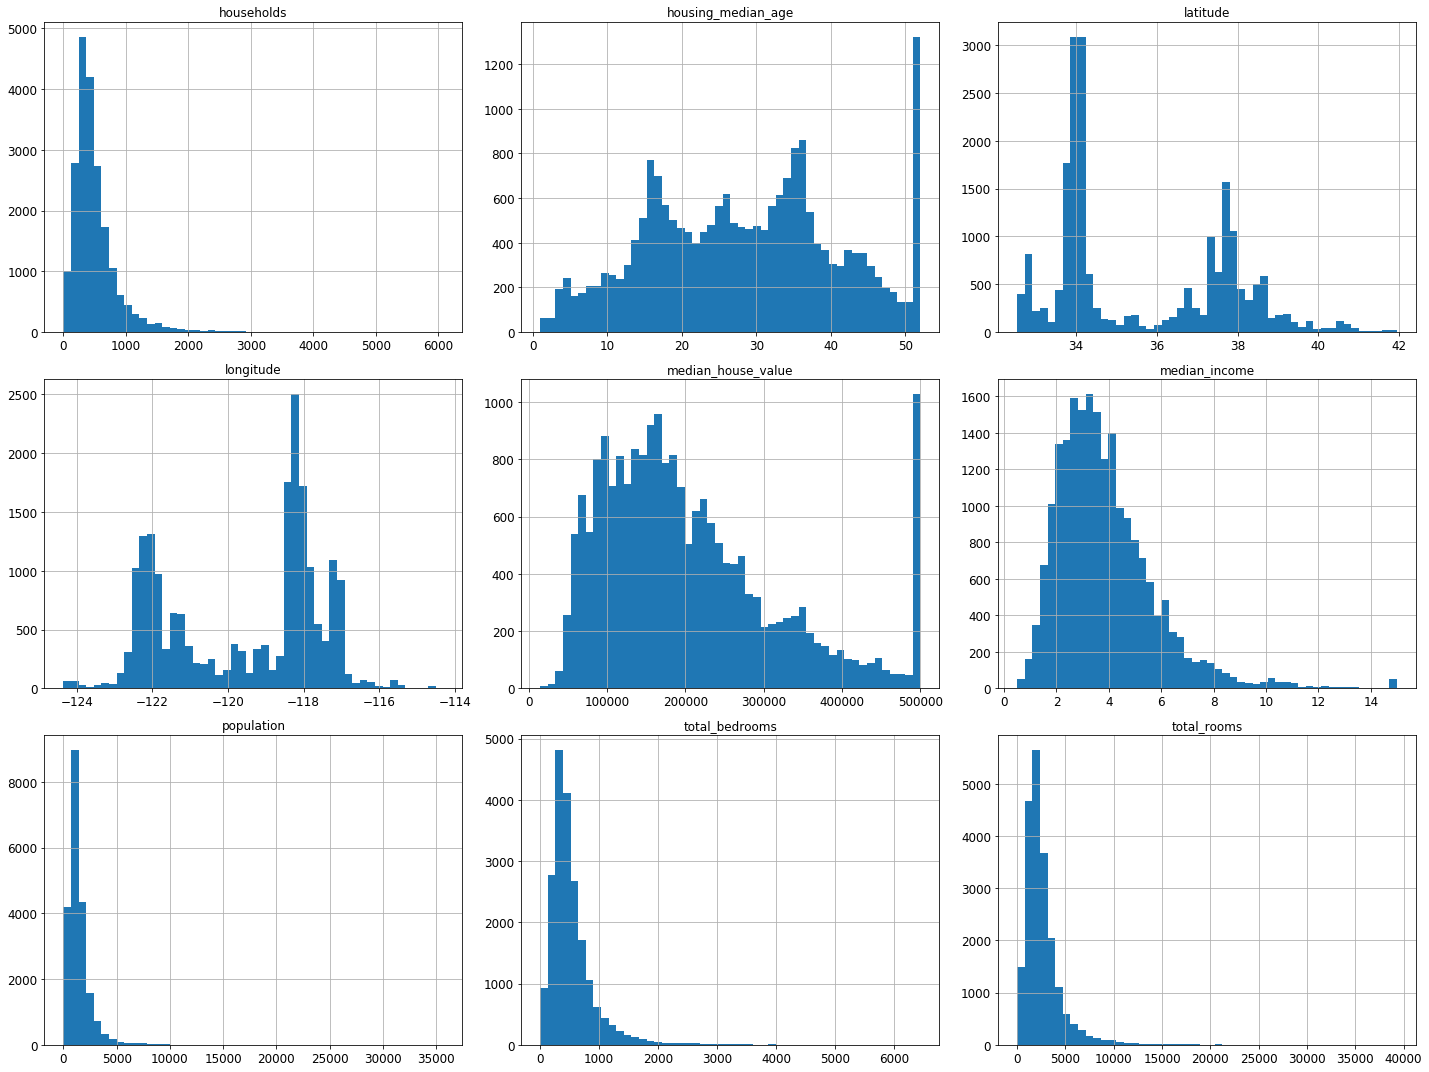

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

Observe algumas coisas nestes histogramas:

1. Primeiro, o atributo de renda mediana não parece estar expresso em dólares americanos (USD). Depois de verificar com a equipe que coletou os dados, você é informado de que os dados foram dimensionados (scaled) e limitados (capped) a 15 (na verdade, 15.0001) para rendimentos médios mais altos e a 0.5 (na verdade, 0.4999) para rendimentos médios mais baixos. Trabalhar com atributos pré-processados é comum em Machine Learning, e isso não é necessariamente um problema, mas você deve tentar entender como os dados foram computados.

2. A idade mediana da habitação e o valor mediano da casa também foram limitados. Este último pode ser um problema sério, pois é o seu atributo alvo (seus labels (rótulos)). Seus algoritmos de Machine Learning podem aprender que os preços nunca ultrapassam esse limite. Você precisa verificar com sua equipe de clientes (a equipe que usará a saída do seu sistema) para ver se isso é um problema ou não. Se eles te disserem que precisam de previsões precisas mesmo além de USD500.000, você tem basicamente duas opções: a. Colecione labels apropriadas para os distritos cujos labels foram limitados. b. Remova esses distritos do conjunto de treinamento (e também do conjunto de testes, já que seu sistema não deve ser avaliado mal se ele previr valores acima de USD500.000).

3. Esses atributos têm escalas muito diferentes. Discutiremos isso mais adiante neste notebook quando explorarmos o dimensionamento de features.

4. Finalmente, muitos histogramas são pesados na cauda: eles se estendem muito mais para a direita da mediana do que para a esquerda. Isso pode tornar um pouco mais difícil para alguns algoritmos de Machine Learning detectar padrões. Vamos tentar transformar esses atributos mais tarde para ter uma distribuição em forma de sino (Gaussiana).

Com isso agora ja temos uma melhor compreensão do tipo de dados que estamos lidando.

In [0]:
# para tornar a saída deste portátil idêntica em todas as execuções
np.random.seed(42)

### Criar um conjunto de teste

Pode parecer estranho separar voluntariamente parte dos dados nesta fase. Afinal, você só demos uma rápida olhada nos dados, e certamente deveriamos aprender muito mais sobre eles antes de decidir quais algoritmos usar, certo? 

Isso é verdade, mas seu cérebro é um incrível sistema de detecção de padrões, o que significa que é altamente propenso a overfitting: se você olhar para o conjunto de testes, pode se deparar com algum padrão aparentemente interessante nos dados de teste que o leva a selecionar um tipo específico de modelo de Machine Learning. 

Quando você estimar o erro de generalização usando o conjunto de testes, sua estimativa será otimista demais e você iniciará um sistema que não terá o desempenho esperado. Isso é chamado de ***data snooping bias*** (viés de bisbilhotar os dados). 

Criar um conjunto de testes é teoricamente bastante simples: basta escolher algumas instâncias aleatoriamente, geralmente 20% do conjunto de dados, e separá-las:

In [0]:
import numpy as np

# Apenas para ilustração. Sklearn possui a função train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

Você pode então usar essa função assim:

In [0]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


Bem, isso funciona, mas não é perfeito: se você executar o programa novamente, ele gerará um conjunto de testes diferente! 

Com o tempo, você (ou seus algoritmos de Machine Learning) poderá ver todo o conjunto de dados, que é o que você deseja evitar. 

Uma solução é salvar o conjunto de testes na primeira execução e depois carregá-lo em execuções subseqüentes. Outra opção é definir a semente do gerador de números aleatórios (por exemplo, `np.random.seed(42)`) antes de chamar `np.random.permutation()`, para que sempre gere os mesmos índices embaralhados.

Mas ambas as soluções não funcionariam da próxima vez que você buscar um conjunto de dados atualizado. 

Uma solução comum é usar o identificador de cada instância para decidir se deve ou não entrar no conjunto de testes (supondo que as instâncias possuam um identificador único e imutável). 

Por exemplo, você pode calcular um hash do identificador de cada instância, manter apenas o último byte do hash e colocar a instância no conjunto de testes se esse valor for menor ou igual a 51 (~ 20% de 256). 

Isso garante que o conjunto de testes permaneça consistente em várias execuções, mesmo se você atualizar o conjunto de dados. O novo conjunto de testes conterá 20% das novas instâncias, mas não conterá nenhuma instância anterior no conjunto de treinamento. 

Aqui está uma implementação possível:

In [0]:
from zlib import crc32
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Infelizmente, o conjunto de dados não possui uma coluna identificadora. A solução mais simples é usar o índice de linhas como o ID:

In [0]:
housing_with_id = housing.reset_index()   # adiciona uma coluna `index`
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

Se você usar o índice de linha como um identificador exclusivo, precisará garantir que os novos dados sejam anexados ao final do conjunto de dados e que nenhuma linha seja excluída. 

Se isso não for possível, você poderá tentar usar os features mais estáveis para criar um identificador exclusivo. 

Por exemplo, a latitude e a longitude de um distrito têm a garantia de estabilidade (por nao mudarem), então você pode combiná-las em um ID como esse:

In [0]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [0]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


O `Scikit-Learn` fornece algumas funções para dividir conjuntos de dados em vários subconjuntos de várias maneiras. A função mais simples é o `train_test_split`, que faz basicamente a mesma coisa que a função `split_train_test` definida anteriormente, com alguns recursos adicionais. 

Primeiro, há um parâmetro `random_state` que permite que você defina a semente do gerador aleatório como explicado anteriormente, e segundo você pode passar vários conjuntos de dados com um número idêntico de linhas, e os dividirá nos mesmos índices (isso é muito útil, para exemplo, se você tiver um DataFrame separado para labels):

In [0]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [0]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


Até agora, consideramos métodos de amostragem puramente aleatórios. 

Isso geralmente é bom se o seu conjunto de dados for grande o suficiente (especialmente em relação ao número de atributos), mas se não for, você corre o risco de introduzir um bias de amostragem significativo. 

Quando uma empresa de pesquisa decide ligar para 1.000 pessoas para fazer algumas perguntas, elas não escolhem apenas 1.000 pessoas aleatoriamente. Eles tentam garantir que essas 1.000 pessoas sejam representativas de toda a população. 
________________________________________________________________________________
**NOTA:** O Teorema do Limite Central nos garante que um conjunto de dados que foram amostrados de forma realmente aleatoria representam fielmente a populacao a qual pertencem.
________________________________________________________________________________
Por exemplo, a população dos EUA é composta por 51,3% de mulheres e 48,7% de homens, então uma pesquisa bem conduzida nos EUA tentaria manter essa proporção na amostra: 513 mulheres e 487 homens. 

Isso é chamado de amostragem estratificada: a população é dividida em subgrupos homogêneos chamados estratos, e o número certo de instâncias é amostrado de cada estrato para garantir que o conjunto de testes seja representativo da população total. Se eles usaram amostragem puramente aleatória, haveria cerca de 12% de chance de amostrar um teste de teste com menos de 49% de mulheres ou mais de 54% de mulheres. 

De qualquer maneira, os resultados da pesquisa seriam significativamente tendenciosos.

Suponha que você tenha conversado com especialistas que lhe disseram que a renda média é um atributo muito importante para prever os preços médios da moradia. 

Você pode querer garantir que o conjunto de testes seja representativo das várias categorias de renda em todo o conjunto de dados.

Como a renda média é um atributo numérico contínuo, primeiro você precisa criar um atributo de categoria de renda. Vamos olhar o histograma de renda mediana mais de perto:

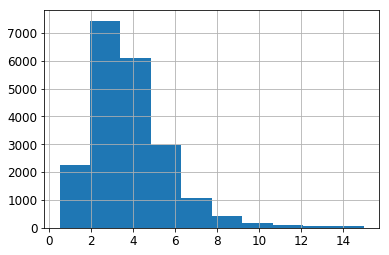

In [0]:
housing["median_income"].hist()

A maioria dos valores médios de renda estão agrupados em torno de 2 a 5 (dezenas de milhares de dólares), mas algumas rendas médias vão muito além de 6. 

É importante ter um número suficiente de instâncias no seu conjunto de dados para cada estrato, ou então a estimativa da importância do estrato pode ser tendenciosa (conter bias). 

Isso significa que você não deve ter muitos estratos, e cada estrato deve ser grande o suficiente. 

O código a seguir cria um atributo de categoria de renda dividindo a renda mediana por 1,5 (para limitar o número de categorias de renda) e arredondando usando ceil (para ter categorias distintas) e mesclando todas as categorias superiores a 5 na categoria 5:

In [0]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [0]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

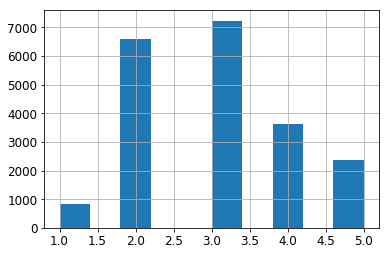

In [0]:
housing["income_cat"].hist()

In [0]:
!pip install scikit-image
from skimage.util import montage

In [0]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

Agora estamos prontos para fazer amostragem estratificada com base na categoria de renda. Para isso, você pode usar a classe `StratifiedShuffleSplit` do Scikit-Learn:

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Vamos ver se isso funcionou como esperado. Você pode começar observando as proporções da categoria de renda no dataset completo:

In [0]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

Com código semelhante, podemos medir as proporções da categoria de renda no conjunto de testes.

In [0]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [0]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

Vamos comparar as proporcoes dos dados estratificados com os normais.

In [0]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [0]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114583,0.109496,-4.318374,0.127011


Agora devemos remover o atributo `income_cat` para que os dados voltem ao estado original:

In [0]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Passamos um bom tempo na geração de conjuntos de teste por um bom motivo: essa é uma parte frequentemente negligenciada, mas crítica, de um projeto de Machine Learning. 

Além disso, muitas dessas ideias serão úteis mais tarde quando discutirmos a validação cruzada. Agora é hora de passar para o próximo estágio: explorar os dados.

# Visualização os Dados para Obter Intuições (Insights) do Problema

Até agora, só demos uma rápida olhada nos dados para obter uma compreensão geral do tipo de dados que está manipulando. Agora o objetivo é ir um pouco mais a fundo. 

Primeiro, certifique-se de colocar o teste de lado e você está explorando apenas o conjunto de treinamento. Além disso, se o conjunto de treinamento for muito grande, convém testar um conjunto de exploração para facilitar e agilizar as manipulações. 

No nosso caso, o conjunto é bem pequeno, então você pode trabalhar diretamente no conjunto completo. Vamos criar uma cópia para que possamos trabalhar sem prejudicar o conjunto de treinamento:

In [0]:
housing = strat_train_set.copy()

## Visualizando dados geográficos

Como existe informação geográfica (latitude e longitude), é uma boa idéia criar um gráfico de dispersão (scatter) de todos os distritos para visualizar os dados....

Saving figure visualização_ruim_plot


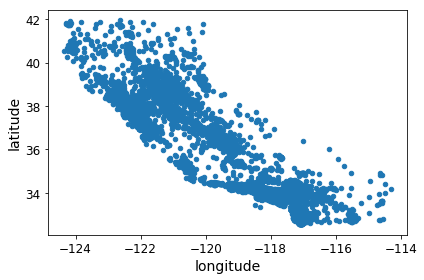

In [0]:
housing.plot(kind="scatter", x="longitude", y="latitude")


Parece Califórnia, mas, além disso, é difícil ver qualquer padrão em particular. Definir a opção alfa como 0.1 torna muito mais fácil visualizar os locais onde há uma alta densidade de pontos de dados

Saving figure visualização_melhor_plot


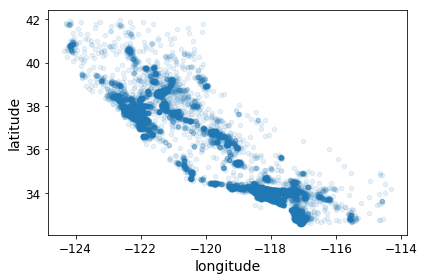

In [0]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)


Bem melhor: você pode ver claramente as áreas de alta densidade, ou seja, a Bay Area e ao redor de Los Angeles e San Diego, além de uma longa linha de alta densidade no Central Valey, especialmente em Sacramento e Fresno.

Mais genericamente, nossos cérebros são muito bons em identificar padrões em imagens, mas você pode precisar mexer com os parâmetros de visualização para fazer com que os padrões se destaquem.

Agora vamos olhar para os preços da habitação. O raio de cada círculo representa a população do distrito (opção s) e a cor representa o preço (opção c). 

Usaremos um mapa de cores pré-definido (opção cmap) chamado jet, que varia de azul (valores baixos) a vermelho (preços altos)

Saving figure precos_casas_scatterplot


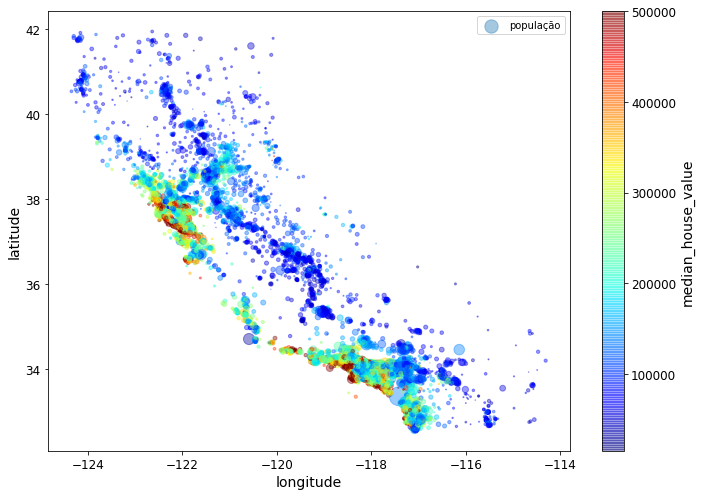

In [0]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="população", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

plt.legend()


Esta imagem acima indica que os preços da habitação estão muito relacionados com a localização (por exemplo, perto do oceano) e com a densidade populacional, o que ja era de se esperar. 

Provavelmente será útil usar um algoritmo de clustering para detectar os clusters principais e adicionar novos features que medem a proximidade dos centros do cluster. 

O atributo de proximidade oceânica também pode ser útil, embora no norte da Califórnia os preços da habitação nos distritos costeiros não sejam muito altos, por isso não é uma regra.

Podemos tambem visualizar o mapa geografico junto com os dados:

Saving figure preços_habitação_califórnia_plot


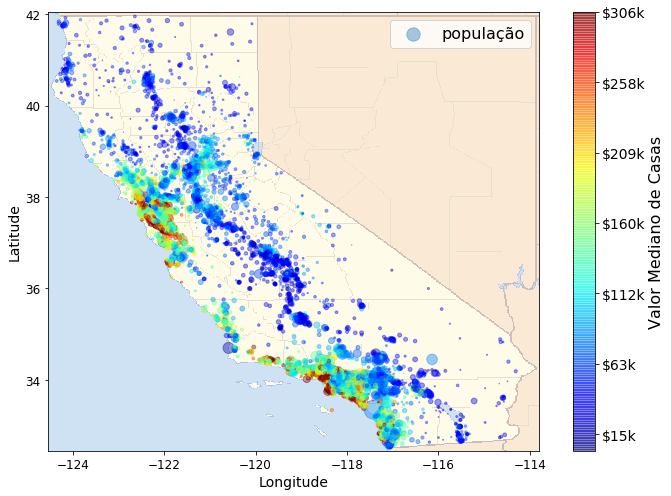

In [0]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/projeto_ponta_a_ponta/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="população",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Valor Mediano de Casas', fontsize=16)

plt.legend(fontsize=16)
plt.show()

## Procurando por correlações

Como o conjunto de dados não é muito grande, podemos calcular facilmente o coeficiente de correlação padrão (também chamado r de Pearson) entre cada par de atributos usando o método `corr()`:

In [0]:
corr_matrix = housing.corr()

Agora, vamos analisar quanto cada atributo se correlaciona com o valor médio das casas:

In [0]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

O coeficiente de correlação varia de –1 a 1. 

Quando está próximo de 1, isso significa que existe uma forte correlação positiva; por exemplo, o valor mediano da casa tende a subir quando a renda média aumenta. 

Quando o coeficiente está próximo de –1, isso significa que há uma forte correlação negativa; você pode ver uma pequena correlação negativa entre a latitude e o valor mediano da casa (ou seja, os preços têm uma leve tendência de cair quando você vai para o norte). 

Finalmente, coeficientes próximos de zero significam que não há correlação linear. 

**NOTA:** O coeficiente de correlação mede apenas as correlações lineares (“se x sobe, então y geralmente sobe / desce”). Pode perder completamente relações não-lineares (por exemplo, “se x estiver próximo de zero, então y geralmente aumenta”).

Outra maneira de verificar a correlação entre os atributos é usar a função `scatter_matrix` do Pandas, que plota todos os atributos numéricos em relação a todos os outros atributos numéricos. 

Como agora existem 11 atributos numéricos, você teria 112 = 121 gráficos, que não caberiam em uma página, então vamos nos concentrar em alguns atributos promissores que parecem estar mais correlacionados com o valor mediano da habitação:

Saving figure scatter_matrix_plot


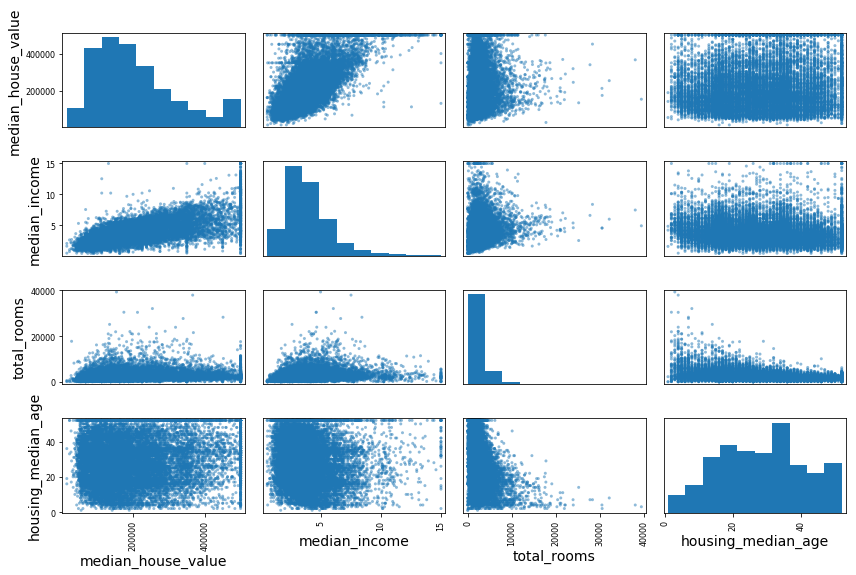

In [0]:
# from pandas.tools.plotting import scatter_matrix # Para versoes mais antigas do Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

A diagonal principal (superior esquerda a direita inferior) estaria cheia de linhas retas se Pandas traçasse cada variável contra si mesma, o que não seria muito útil. 

Então, em vez disso, o Pandas exibe um histograma de cada atributo (outras opções estão disponíveis; consulte a documentação do Pandas para obter mais detalhes). 

O atributo mais promissor para prever o valor mediano da casa é a renda média, portanto, vamos ampliar o gráfico de dispersão da correlação:

Saving figure renda_por_valor_casa_mediano_scatterplot


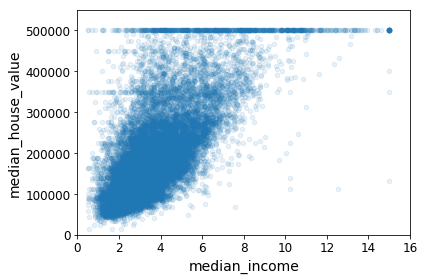

In [0]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

Este plot revela algumas coisas. 

Primeiro, a correlação é de fato muito forte; você pode ver claramente a tendência ascendente e os pontos não estão muito dispersos. 

Segundo, o limite de preço que percebemos anteriormente é claramente visível como uma linha horizontal de USD500.000. Mas esse plot revela outras linhas retas menos óbvias: uma linha horizontal em torno de USD450.000, outra em torno de USD350.000, talvez uma em torno de USD280.000, e mais algumas abaixo disso. 

Podemos tentar remover os distritos correspondentes para evitar que o algoritmo aprenda a reproduzir essas peculiaridades de dados.

## Experimentando com combinações de atributos

Ate agora vimos algumas maneiras de explorar os dados e obter insights. Identificamos algumas peculiaridades de dados que você pode querer limpar antes de alimentar os dados em um algoritmo de Machine Learning e encontramos correlações interessantes entre os atributos, em particular com o atributo de destino. 

Também notamos que alguns atributos têm uma distribuição pesada, portanto você pode querer transformá-los (por exemplo, calculando seu logaritmo). 

Naturalmente, sua tudo isso varia consideravelmente com cada projeto, mas as ideias gerais são semelhantes.

Uma última coisa que você pode querer fazer antes de preparar os dados para algoritmos de Machine Learning é experimentar várias combinações de atributos.

Por exemplo, o número total de comodos em um distrito não é muito útil se você não souber quantos domicílios existem. O que você realmente quer é o número de comodos por domicílio. 

Da mesma forma, o número total de quartos por si só não é muito útil: você provavelmente deseja compará-lo com o número de comodos. A população por família também parece ser uma interessante combinação de atributos para se olhar. Vamos criar esses novos atributos:

In [0]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

E agora vamos ver a matriz de correlação novamente:

In [0]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

O novo atributo `bedrooms_per_room` é muito mais correlacionado com o valor médio da casa do que o número total de quartos ou quartos. Aparentemente, casas com uma relação quarto / quarto menor tendem a ser mais caras. 

O número de cômodos por domicílio também é mais informativo do que o número total de cômodos de um distrito (obviamente, quanto maiores as casas, mais caras elas são).

Esta rodada de exploração não precisa ser absolutamente completa; o ponto é começar com o pé direito e obter rapidamente insights que ajudarão você a obter um primeiro protótipo razoavelmente bom. 

Mas este é um processo iterativo: assim que você tiver um protótipo instalado e funcionando, poderá analisar sua saída para obter mais insights e voltar a essa etapa de exploração.

# Prepare os dados para algoritmos de Aprendizado de Máquina

Vamos preparar os dados para seus algoritmos de Machine Learning. Em vez de apenas fazer isso manualmente, vamos escrever funções para fazer isso, por várias boas razões:

• Isso permitirá que você reproduza essas transformações facilmente em qualquer conjunto de dados (por exemplo, na próxima vez que você obtiver um novo conjunto de dados).

• Você construirá gradualmente uma biblioteca de funções de transformação que poderá ser reutilizada em projetos futuros.

• Você pode usar essas funções em seu sistema ao vivo para transformar os novos dados antes de alimentá-los com seus algoritmos.

• Isso possibilitará que você tente facilmente várias transformações e veja qual combinação de transformações funciona melhor.

Mas primeiro vamos reverter para um conjunto de treinamento limpo (copiando `strat_train_set` novamente), e vamos separar os preditores e os labels, já que não necessariamente queremos aplicar as mesmas transformações aos preditores e aos valores de destino (observe que `drop()` cria uma cópia dos dados e não afeta `strat_train_set`):

In [0]:
housing = strat_train_set.drop("median_house_value", axis=1) # largar rótulos para conjunto de treinamento
housing_labels = strat_train_set["median_house_value"].copy()

# Limpeza de Dados

A maioria dos algoritmos de Machine Learning não funcionam com features ausentes (quando alguma coluna esta com dados faltando), portanto, vamos criar algumas funções para cuidar desse tipo de problema. Você percebeu anteriormente que o atributo `total_bedrooms` tem alguns valores ausentes, então vamos corrigir isso. Temos três opções:

• Livrar-se dos distritos correspondentes.

• Livrar-se de todo o atributo.

• Defina os valores para algum valor (zero, a média, a mediana, etc.).

Você pode fazer isso facilmente usando os métodos `dropna()`, `drop()` e `fillna()` do DataFrame:

`housing.dropna(subset=["total_bedrooms"])` # opção 1

`housing.drop("total_bedrooms", axis=1)` # opção 2

`median=housing["total_bedrooms"].median()`
`housing["total_bedrooms"].fillna(median)` # opção 3

Vamos ver como funciona cada um:

In [0]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [0]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # opção 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [0]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # opção 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [0]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # opção 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


**Atenção **: Desde o Scikit-Learn 0,20, a classe `sklearn.preprocessing.Imputer` foi substituída pela classe `sklearn.impute.SimpleImputer` class.

O Scikit-Learn fornece uma classe útil para cuidar de valores ausentes: `Imputer`. 

Primeiro, você precisa criar uma instância de `Imputer`, especificando que deseja substituir os valores ausentes de cada atributo pela mediana desse atributo:

In [0]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

Como a mediana só pode ser calculada em atributos numéricos, precisamos criar uma cópia dos dados sem o atributo de texto `ocean_proximity`:

In [0]:
housing_num = housing.drop('ocean_proximity', axis=1)
# alternativamente: housing_num = housing.select_dtypes(include=[np.number])

Agora podemos ajustar a instância imputada aos dados de treinamento usando o método `fit()`:

In [0]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

O `Imputer` simplesmente calculou a mediana de cada atributo e armazenou o resultado em sua variável de instância `statistics_`. Apenas o atributo `total_bedrooms` tinha valores omissos, mas não podemos ter certeza de que não haverá valores ausentes em novos dados depois que o sistema entrar em produção. Por isso, é mais seguro aplicar o `Imputer` a todos os atributos numéricos:

In [0]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Verifique se isso é o mesmo que calcular manualmente a mediana de cada atributo:

In [0]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Agora podemos usar esse `imputer` “treinado” para transformar o conjunto de treinamento substituindo os valores ausentes pelas medianas aprendidas:

In [0]:
X = imputer.transform(housing_num)

O resultado é um array Numpy simples contendo os features transformados. Se você quiser colocá-lo de volta em um DataFrame do Pandas, é simples:

In [0]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [0]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [0]:
imputer.strategy

'median'

In [0]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


# Manipulando texto e atributos categóricos

Anteriormente, deixamos de fora o atributo categórico `ocean_proximity` porque é um atributo de texto, portanto, não podemos calcular sua mediana. 

A maioria dos algoritmos de Machine Learning prefere trabalhar com números, portanto, vamos converter esses rótulos de texto em números.

O Scikit-Learn fornece um transformador para essa tarefa chamado `LabelEncoder`:

In [0]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3], dtype=int64)

Agora podemos usar esses dados numéricos em qualquer algoritmo de Machine Learning. Você pode olhar para o mapeamento que este codificador aprendeu usando o atributo `classes_` (“<1H OCEAN” é mapeado para 0, “INLAND” é mapeado para 1, etc.):...

In [0]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


Um problema com esta representação é que os algoritmos de ML assumirão que dois valores próximos são mais semelhantes que dois valores distantes. Obviamente, este não é o caso (por exemplo, as categorias 0 e 4 são mais semelhantes que as categorias 0 e 1). 

Para corrigir esse problema, uma solução comum é criar um atributo binário por categoria: um atributo igual a 1 quando a categoria for “<1H OCEAN” (e 0 caso contrário), outro atributo igual a 1 quando a categoria é "INLAND" (e 0 caso contrário) e assim por diante. 

Isso é chamado de codificação simples (***one-hot encoding***), porque apenas um atributo será igual a 1 (***hot***), enquanto os outros serão 0 (****cold***).

O Scikit-Learn fornece um codificador `OneHotEncoder` para converter valores categóricos inteiros em ***vetores one-hot***. Vamos codificar as categorias como ***vetores one-hot***. Note que `fit_transform()` espera um array 2D, mas `housing_cat_encoded` é um array 1D, então precisamos reformulá-lo:

In [0]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Observe que a saída é uma matriz esparsa SciPy, em vez de uma matriz NumPy. Isso é muito útil quando você tem atributos categóricos com milhares de categorias. Após a codificação one-hot, obtemos uma matriz com milhares de colunas, e a matriz está cheia de zeros, exceto por um 1 por linha. Usar toneladas de memória principalmente para armazenar zeros seria um desperdício, então, em vez disso, uma matriz esparsa armazena apenas a localização dos elementos diferentes de zero. 

Você pode usá-lo principalmente como um array 2D normal, mas se você realmente quiser convertê-lo em um array NumPy (denso), basta chamar o método `toarray()`:

In [0]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Podemos aplicar ambas as transformações (de categorias de texto a categorias inteiras e, em seguida, de categorias inteiras para ***vetores one-hot***) de uma só vez usando classe`LabelBinarizer`:

In [0]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

**Note:** Isso retorna um array denso NumPy por padrão. Você pode obter uma matriz esparsa ao passar `sparse_output=True` para o construtor `LabelBinarizer`.

# Transformadores Personalizados

Embora o Scikit-Learn ofereça muitos transformadores úteis, você precisará escrever o seu próprio para tarefas como operações de limpeza personalizadas ou combinação de atributos específicos. 

Você vai querer que seu transformador funcione perfeitamente com as funcionalidades do Scikit-Learn (como pipelines), e tudo que você precisa é criar uma classe e implementar três métodos: `fit()` (retornando self), `transform()` e `fit_transform()`. Você pode obter o último gratuitamente simplesmente adicionando `TransformerMixin` como uma classe base. 

Além disso, se você adicionar `BaseEstimator` como uma classe base (e evitar `*args` e `**kargs` em seu construtor), você obterá dois métodos extras (`get_params()` e `set_params()`) que serão úteis para ajuste automático de hiperparâmetro. 

Por exemplo, aqui está uma pequena classe de transformadores que adiciona os atributos combinados que discutimos anteriormente:

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

# garantir os indices das colunas certas: melhor que programar individualmente os indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Neste exemplo, o transformador tem um hiperparâmetro, `add_bedrooms_per_room`, definido como `True` por padrão. 

Este hiperparâmetro permitirá que você descubra facilmente se adicionar este atributo ajuda ou não os algoritmos de Machine Learning. Em geral, você pode adicionar um hiperparâmetro para bloquear qualquer etapa de preparação de dados sobre a qual não tenha 100% de certeza. 

Quanto mais você automatizar essas etapas de preparação de dados, mais combinações poderá experimentar automaticamente, tornando muito mais provável que você encontre uma ótima combinação (e economizando muito tempo).

# Dimensionamento de Features (Feature Scaling)

Uma das transformações mais importantes que você precisa aplicar aos seus dados é o dimensionamento de features. Com poucas exceções, os algoritmos de ML não apresentam bom desempenho quando os atributos numéricos de entrada têm escalas muito diferentes. 

Este é o caso para os dados da habitação: o número total de comodos varia de 6 a 39.320, enquanto a renda média varia apenas de 0 a 15. Observe que o dimensionamento dos valores-alvo geralmente não é requerido.

Existem duas maneiras comuns de obter todos os atributos para ter a mesma escala: padronização e escalonamento min-max. O escalonamento mínimo-máximo (muitas pessoas chamam isso de normalização) é bastante simples: os valores são alterados e redimensionados para que eles variem de 0 a 1. Fazemos isso subtraindo o valor min e dividindo pelo máximo menos o min. O Scikit-Learn fornece um transformador chamado `MinMaxScaler` para isso. Ele tem um Hiperparametro `feature_range` que permite alterar o intervalo se você não quiser 0–1 por algum motivo.

A padronização é bem diferente: primeiro, ela subtrai o valor médio (portanto, os valores padronizados sempre têm uma média zero) e, em seguida, divide-se pela variância para que a distribuição resultante tenha variância unitária. Ao contrário do escalonamento min-max, a padronização não vincula valores a um intervalo específico, o que pode ser um problema para alguns algoritmos (por exemplo, as redes neurais geralmente esperam um valor de entrada variando de 0 a 1). No entanto, a padronização é muito menos afetada pelos outliers. Por exemplo, suponha que um distrito tenha uma renda mediana igual a 100 (por engano). O escalonamento mínimo-máximo esmagaria todos os outros valores de 0 a 15 para 0 a 0,15, enquanto a padronização não seria muito afetada. O Scikit-Learn fornece um transformador chamado `StandardScaler` para padronização.

**NOTA:** Como em todas as transformações, é importante ajustar os dimensionamentos somente aos dados de treinamento, não ao conjunto de dados completo (incluindo o conjunto de testes). Só então você pode usá-los para transformar o conjunto de treinamento e o conjunto de testes (e novos dados).

# Pipelines de Transformação

Como você pode ver, existem muitas etapas de transformação de dados que precisam ser executadas na ordem correta. Felizmente, o Scikit-Learn fornece a classe `Pipeline` para ajudar com essas sequências de transformações. Aqui está um pequeno pipeline para os atributos numéricos:

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [0]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

O construtor `Pipeline` usa uma lista de pares de nomes / estimadores que definem uma seqüência de etapas. Todos, exceto o último estimador, devem ser transformadores (isto é, devem ter um método `fit_transform()`). 

Os nomes podem ser o que você quiser. Quando você chama o método `fit()` do pipeline, ele chama `fit_transform()` seqüencialmente em todos os transformadores, passando a saída de cada chamada como parâmetro para a próxima chamada, até atingir o estimador final, para o qual ele apenas chama o método `fit()`. 

O pipeline expõe os mesmos métodos que o estimador final. Neste exemplo, o último estimador é um `StandardScaler`, que é um transformador, portanto, o pipeline tem um método `transform()` que aplica todas as transformações aos dados em sequência (também possui um método `fit_transform` que poderíamos ter usado em vez de chamando `fit()` e depois `transform()`.

Agora temos um pipeline para valores numéricos e também precisa aplicar o `LabelBinarizer` nos valores categóricos: como podemos unir essas transformações em um único pipeline? 

O Scikit-Learn fornece uma classe `FeatureUnion` para isso. Você fornece uma lista de transformadores (que podem ser pipelines inteiros de transformadores) e quando seu método `transform()` é chamado, ele executa o método `transform()` de cada transformador em paralelo, aguarda sua saída e concatena-os e retorna o resultado (e, claro, chamar seu método `fit()` chama todo método `fit()` de cada transformador. Um pipeline completo que manipule atributos numéricos e categóricos pode ser mais ou menos assim:

**Atenção** : É preferível usar a classe `ColumnTransformer` que foi introduzida no Scikit-Learn 0.20. Se você está usando uma versão mais antiga do Scikit-Learn, você pode importá-lo do `future_encoders.py`:

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
from future_encoders import OneHotEncoder

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [0]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [0]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [0]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [0]:
housing_prepared.shape

(16512, 16)

Para referência, aqui está a antiga solução baseada em um transformador `DataFrameSelector` (para apenas selecionar um subconjunto das colunas` DataFrame` do Pandas), e um `FeatureUnion`:

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

# Crie uma classe para selecionar colunas numéricas ou categóricas
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Agora vamos unir todos esses componentes em um grande pipeline que irá pré-processar os recursos numéricos e categóricos (novamente, poderíamos usar `CombinedAttributesAdder()` em vez de `FunctionTransformer(...)` se preferirmos):

In [0]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [0]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [0]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [0]:
housing_prepared.shape

(16512, 16)

O resultado é o mesmo que com o `ColumnTransformer`:

In [0]:
np.allclose(housing_prepared, old_housing_prepared)

True

# Selecionar e Treinar seu modelo

Finalmente! Enquadramos o problema, coletamos e exploramos os dados, testamos um conjunto de treinamento e um conjunto de testes e escrevemos os pipelines de transformação para limpar e preparar os dados automaticamente para algoritmos de MLa. Agora estamos prontos para selecionar e treinar um modelo de ML.

## Treinamento e Avaliação no Conjunto de Treinamento (Training Set)

Vamos primeiro treinar um modelo de regressão linear:

In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Agora ja temos um modelo de Regressão Linear em funcionamento. Vamos experimentá-lo em algumas instâncias do conjunto de treinamento:

In [0]:
# Vamos tentar o pipeline completo de pré-processamento em algumas instâncias de treinamento
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Comparando com os valores reais:

In [0]:
print("Labels:", list(some_labels))

In [0]:
some_data_prepared

In [0]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [0]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

In [0]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

In [0]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

# Ajustes finos (fine-tune) no modelo 

In [0]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [0]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

In [0]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

**Nota**: especificamos `n_estimators=10` para evitar um aviso sobre o fato de que o valor padrão será alterado para 100 no Scikit-Learn 0.22.

In [0]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

In [0]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

In [0]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

In [0]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

In [0]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # Vamos tentar 12 (3×4) combinações de hiperparâmetros
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # Tambem vamos tentar 6 (2×3) combinações com bootstrap como False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# treinar por 5 voltas, para um total de (12+6)*5=90 turnos de treino 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

A melhor combinação de hiperparâmetros encontrada:

In [0]:
grid_search.best_params_

In [0]:
grid_search.best_estimator_

Vejamos a pontuação de cada combinação de hiperparâmetros testada durante a pesquisa da grade (grid search):

In [0]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [0]:
pd.DataFrame(grid_search.cv_results_)

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [0]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [0]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [0]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

In [0]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [0]:
final_rmse

Podemos calcular um intervalo de confiança de 95% para o teste RMSE:

In [0]:
from scipy import stats

In [0]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

Nós poderíamos calcular o intervalo manualmente assim:

In [0]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

Alternativamente, poderíamos usar um z-scores em vez de t-scores:

In [0]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)